In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from stockpy.config import ss_nn_args, shared, training
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stockpy.probabilistic import DeepMarkovModel, GaussianHMM, BayesianNN
from stockpy.neural_network import MLP, LSTM, GRU, BiGRU, BiLSTM
from stockpy.transformer import Transformer
from stockpy.metrics import evaluate
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random

In [2]:
# Generate data

sinewave = np.sin(np.arange(0, 2000, 0.1))
slices = sinewave.reshape(-1, 200)
input_tensor = torch.tensor(slices[:, :-1], dtype=torch.float).unsqueeze(2)
target_tensor = torch.tensor(slices[:, 1:], dtype=torch.float)
print(input_tensor.shape, target_tensor.shape)

torch.Size([100, 199, 1]) torch.Size([100, 199])


In [3]:
# Model - seq2seq model with loop over decoder

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
    def forward(self, x):
        # Forward propagate LSTM
        out, hidden = self.lstm(x)
        
        return out, hidden

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, hidden):
        # Forward propagate LSTM
        out, hidden = self.lstm(x, hidden)
        
        # Pass LSTM output through fully connected layer
        out = self.fc(out)
        
        return out, hidden

class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, sequence_length):
        super(LSTMSeq2Seq, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        
        # Define encoder and decoder
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(input_size, hidden_size, num_layers)
        
    def forward(self, input):
        # Pass input tensor through encoder
        encoder_outputs, hidden = self.encoder(input)
        
        # Initialize input tensor for decoder
        input_t = torch.zeros(self.batch_size, 1, dtype=torch.float).unsqueeze(0)
        
        # Initialize output tensor and hidden state tensor for decoder
        output_tensor = torch.zeros(self.sequence_length, self.batch_size, 1)
        hidden_states = torch.zeros(self.sequence_length, self.num_layers, self.batch_size, self.hidden_size)
        
        # Pass input tensor through decoder at each time step
        for t in range(self.sequence_length):
            output_t, hidden = self.decoder(input_t, hidden)
            output_t = output_t[-1]
            input_t = output_t.unsqueeze(0)
            output_tensor[t] = output_t
            hidden_states[t] = hidden[0]
        
        return output_tensor, hidden_states

In [4]:
# Initialize model
seq2seqA = LSTMSeq2Seq(input_size=1, hidden_size=51, num_layers=1, batch_size=100, sequence_length=199)

# Train model
num_epochs = 200
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(seq2seqA.parameters(), lr=0.001)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    output_tensor, _ = seq2seqA(input_tensor)
    loss = criterion(output_tensor.squeeze().transpose(1,0), target_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('Epoch: {} -- Training loss (MSE) {}'.format(epoch, loss.item()))

Epoch: 0 -- Training loss (MSE) 0.5016876459121704


KeyboardInterrupt: 

In [ ]:
output = output_tensor.squeeze().transpose(0, 1)
output = output[-1].squeeze().detach().numpy()

In [ ]:
target = target_tensor[-1].squeeze().detach().numpy()

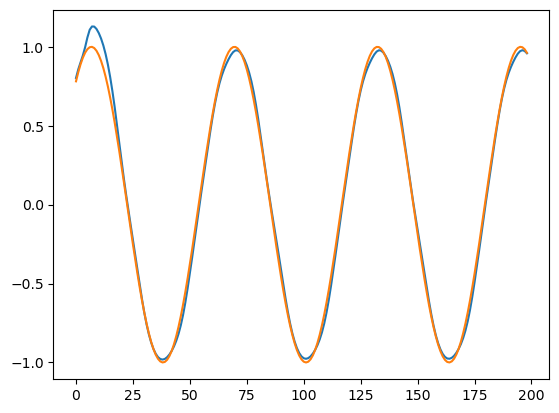

In [ ]:
plt.plot(output)
plt.plot(target)